# 1-D Linear Wave Example

Anthony Gruber 3-31-2023

In [18]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix
# from scipy.linalg import ldl

import ROM_utils_check as ru
import OpInf_utils as ou
from KdV_BBM_utils import tridiag

# To suppress annoying umfpack "almost singular" warnings
import warnings
warnings.filterwarnings('ignore', '.*singular matrix!.*')

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.constrained_layout.use'] = True

## Define functions for generating data

In [19]:
# Global parameter for Hamiltonian
c = 0.1


# # Define hamiltonian (depends on c)
# def Hamil(x, dx):
#     q, p  = np.split(x, 2, axis=0)
#     arr   = np.zeros_like(q)
#     const = c**2 / (4*dx**2)

#     # Recall periodic boundary conditions...
#     arr[0]    = 0.5 * p[0]**2 + const * ( 
#                 (q[1]-q[0])**2 + (q[0]-q[-1])**2 )
#     arr[1:-1] = 0.5 * p[1:-1]**2 + const * ( 
#                 (q[2:]-q[1:-1])**2 + (q[1:-1]-q[0:-2])**2 )
#     arr[-1]   = 0.5 * p[-1]**2 + const * ( 
#                 (q[0]-q[-1])**2 + (q[-1]-q[-2])**2 )
#     return np.sum(arr, axis=0)


# IC function
def s(x, a ,b): return a * np.abs(x - b)
def h(s): return np.where(s<=1, 1 - 3/2*s**2 + 3/4*s**3,
                          np.where(s<=2, 1/4*(2-s)**3, 0))
# def f(x): return 1 * np.exp(-(x-0.5)**2 / (2*0.02**2))


# Function to assemble FOM operators
def assemble_FOM(Nover2, xEnds):
    xRange = np.linspace(xEnds[0], xEnds[1], Nover2)
    dx     = xRange[1] - xRange[0]

    # Build J
    zz     = np.zeros((Nover2, Nover2))
    ii     = np.eye(Nover2)
    J      = csc_matrix(np.block([[zz, ii], [-ii, zz]]))

    # Build A s.t. gradH(x) = Ax
    qxx       = tridiag(np.ones(Nover2-1), -2*np.ones(Nover2),
                          np.ones(Nover2-1))
    qxx[-1,0] = 1
    qxx[0,-1] = 1
    qxx      *= (c/dx)**2
    A         = csc_matrix(np.block([[-qxx, zz], [zz, ii]]))

    return J, A

## Generating training/testing data

/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_29438/3840317094.py:60: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


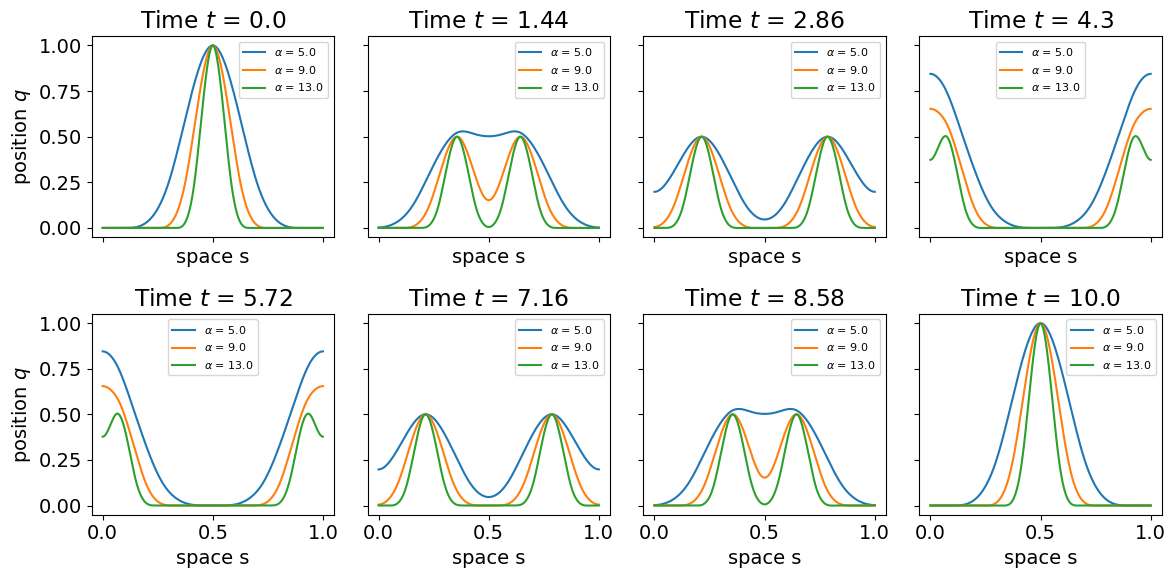

In [20]:
# Parameters for training
Nover2 = 500
Nt     = 501
T      = 10

# Ranges for training
xTrain = np.linspace(0, 1, Nover2)
tTrain = np.linspace(0, T, Nt)

# Generating ICs, 1-parameter family
npts = 11
aRange = np.linspace(5, 15, npts)
ICgrid = np.zeros((len(aRange), Nover2*2))

for i,a in enumerate(aRange):
    ICgrid[i] = np.concatenate((h(s(xTrain, a, 0.5)),
                                    np.zeros(Nover2)), axis=0)

# Assemble FOM and compute snapshots
J, A       = assemble_FOM(Nover2, [0,1])
X, Xd, gH  = ru.integrate_Linear_HFOM(tTrain, ICgrid[0], J, A)
# M          = 0.5*(A+A.T)
# L, D, _    = ldl(M.todense())
# L = csc_matrix(L); D = csc_matrix(D)

# for mean centering
Xmc = X - ICgrid[0].reshape(-1,1)

for i,ic in enumerate(ICgrid[1:]):
    sol, soldot, grad = ru.integrate_Linear_HFOM(tTrain, ic, J, A)
    X  = np.concatenate((X,  sol),    axis=1)
    Xd = np.concatenate((Xd, soldot), axis=1)
    gH = np.concatenate((gH, grad),   axis=1)

    #for mean centering
    solmc = sol - ic.reshape(-1,1)
    Xmc   = np.concatenate((Xmc, solmc), axis=1)


name = "tab10"
cmap = plt.get_cmap(name)


fig, ax = plt.subplots(2, 4, figsize=(12,6), sharey=True, sharex=True)

ax.flatten()[0].set_ylabel(f'position $q$')
ax.flatten()[4].set_ylabel(f'position $q$')

# tList = [0, 50, 100, 150, 200, 250, 375, 500]
tList = [int(np.ceil(500/7*i)) for i in range(8)]
for k,t in enumerate(tList):
    ax.flatten()[k].plot(xTrain, X[:Nover2,t], label=r'$\alpha$ '+f'= {aRange[0]}', linestyle='-')
    ax.flatten()[k].plot(xTrain, X[:Nover2,t+1503], label=r'$\alpha$ '+f'= {aRange[4]}', linestyle='-')
    ax.flatten()[k].plot(xTrain, X[:Nover2,t+3507], label=r'$\alpha$ '+f'= {aRange[8]}', linestyle='-')

    ax.flatten()[k].set_title(f'Time $t$ = {t/50}')
    ax.flatten()[k].set_xlabel(f'space s')

    ax.flatten()[k].legend(prop={'size':8})
plt.tight_layout()
# plt.savefig(f'ParamWaveFOM.pdf', transparent=True)
plt.show()

## Nonparametric version

### Training the POD bases

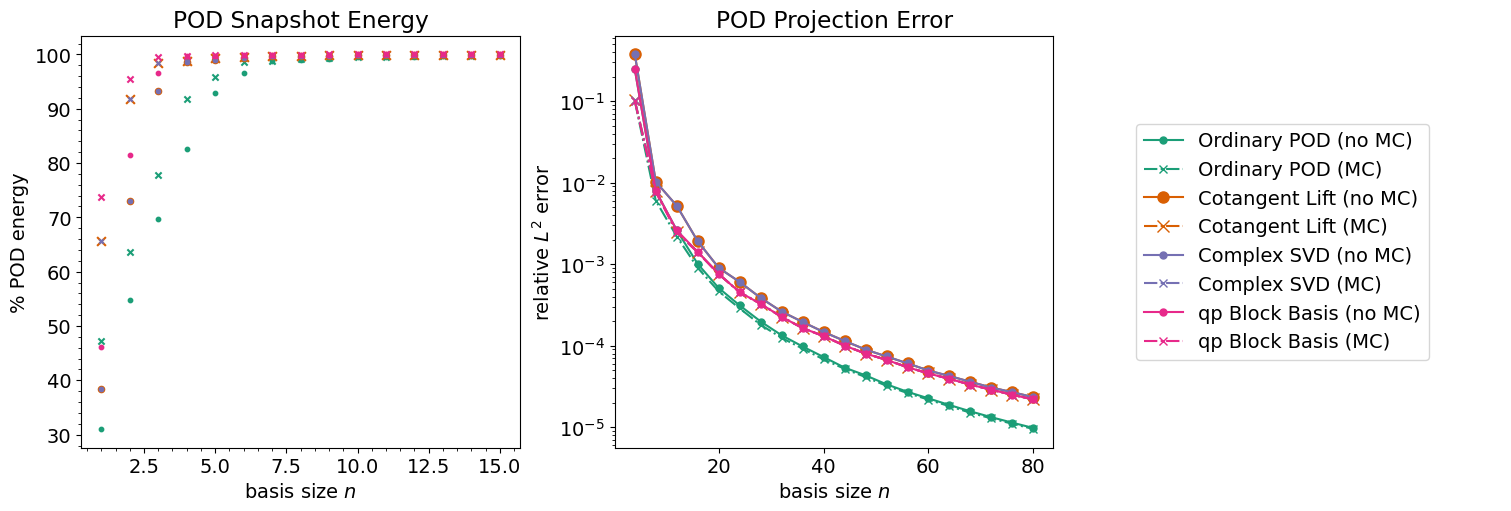

In [21]:
X1 = X[:,:Nt]
Xt1 = Xd[:,:Nt]
gH1 = gH[:,:Nt]

POD   = ru.Linear_Hamiltonian_ROM(X1)
POD.set_reduced_basis('POD', rmax=100)
POD.compute_basis_energies()
PODmc = ru.Linear_Hamiltonian_ROM(X1)
PODmc.set_reduced_basis('POD', centered=True, rmax=100)
PODmc.compute_basis_energies()
CL    = ru.Linear_Hamiltonian_ROM(X1)
CL.set_reduced_basis('cotangent_lift', rmax=100)
CL.compute_basis_energies()
CLmc  = ru.Linear_Hamiltonian_ROM(X1)
CLmc.set_reduced_basis('cotangent_lift', centered=True, rmax=100)
CLmc.compute_basis_energies()
QP    = ru.Linear_Hamiltonian_ROM(X1)
QP.set_reduced_basis('block_qp', rmax=100)
QP.compute_basis_energies()
QPmc  = ru.Linear_Hamiltonian_ROM(X1)
QPmc.set_reduced_basis('block_qp', centered=True, rmax=100)
QPmc.compute_basis_energies()
SVD    = ru.Linear_Hamiltonian_ROM(X1)
SVD.set_reduced_basis('complex_SVD', rmax=100)
SVD.compute_basis_energies()
SVDmc  = ru.Linear_Hamiltonian_ROM(X1)
SVDmc.set_reduced_basis('complex_SVD', centered=True, rmax=100)
SVDmc.compute_basis_energies()

# SS, SSmc     = POD.basis_evals, PODmc.basis_evals
# SS2, SS2mc   = CL.basis_evals, CLmc.basis_evals
# SSq, SSp     = QP.basis_evals
# SSqmc, SSpmc = QPmc.basis_evals

nEigs = 15
idx = [i+1 for i in range(nEigs)]
ic = ICgrid[0].reshape(-1,1)

name = "Dark2"
cmap = plt.get_cmap(name)

nList = [4*(i+1) for i in range(20)]
errU  = np.zeros(len(nList))
errUmc = np.zeros(len(nList))
errU2  = np.zeros(len(nList))
errU2mc = np.zeros(len(nList))
errUqp  = np.zeros(len(nList))
errUqpmc = np.zeros(len(nList))
errUSVD  = np.zeros(len(nList))
errUSVDmc = np.zeros(len(nList))
for i,n in enumerate(nList):

    reconUmc   = PODmc.project(X1, n)
    reconU     = POD.project(X1, n)
    reconU2mc  = CLmc.project(X1, n)
    reconU2    = CL.project(X1, n)
    reconUqpmc = QPmc.project(X1, n)
    reconUqp   = QP.project(X1, n)
    reconUSVDmc = SVDmc.project(X1, n)
    reconUSVD   = SVD.project(X1, n)

    errUmc[i]   = ru.relError(X1, reconUmc)
    errU[i]     = ru.relError(X1, reconU)
    errU2mc[i]  = ru.relError(X1, reconU2mc)
    errU2[i]    = ru.relError(X1, reconU2)
    errUqpmc[i] = ru.relError(X1, reconUqpmc)
    errUqp[i]   = ru.relError(X1, reconUqp)
    errUSVDmc[i] = ru.relError(X1, reconUSVDmc)
    errUSVD[i]   = ru.relError(X1, reconUSVD)

from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, POD.basis_energies[:nEigs], s=10., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, PODmc.basis_energies[:nEigs], s=20., label='Ordinary POD (MC)', marker='x', color=cmap.colors[0])
ax[0].scatter(idx, CL.basis_energies[0][:nEigs], s=20, label='Cotangent Lift (no MC)', color=cmap.colors[1])
ax[0].scatter(idx, CLmc.basis_energies[0][:nEigs], s=40., label='Cotangent Lift (MC)', marker='x', color=cmap.colors[1])
ax[0].scatter(idx, SVD.basis_energies[1][:nEigs], s=10., label='Complex SVD (no MC)', color=cmap.colors[2])
ax[0].scatter(idx, SVDmc.basis_energies[1][:nEigs], s=10., label='Complex SVD (MC)', marker='x', color=cmap.colors[2])
ax[0].scatter(idx, QP.basis_energies[0][:nEigs], s=10., label='q Snapshots Only (no MC)', color=cmap.colors[3])
ax[0].scatter(idx, QPmc.basis_energies[0][:nEigs], s=20., label='q Snapshots Only (MC)', marker='x', color=cmap.colors[3])
# ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, errU, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errUmc, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=6, color=cmap.colors[0])
ax[1].semilogy(nList, errU2, label='Cotangent Lift (no MC)', marker='o', linestyle='-', markersize=8, color=cmap.colors[1])
ax[1].semilogy(nList, errU2mc, label='Cotangent Lift (MC)', marker='x', linestyle='-.', markersize=9, color=cmap.colors[1])
ax[1].semilogy(nList, errUSVD, label='Complex SVD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[2])
ax[1].semilogy(nList, errUSVDmc, label='Complex SVD (MC)', marker='x', linestyle='-.', markersize=6, color=cmap.colors[2])
ax[1].semilogy(nList, errUqp, label='qp Block Basis (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[3])
ax[1].semilogy(nList, errUqpmc, label='qp Block Basis (MC)', marker='x', linestyle='-.', markersize=6, color=cmap.colors[3])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
# ax[1].legend(prop={'size': 8})

lines, labels = ax[1].get_legend_handles_labels()
ax[2].axis('off')
ax[2].legend(lines, labels, loc='center', ncol=1)

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
# plt.tight_layout()
plt.savefig('WavePODenergy.pdf', transparent=True)
plt.show()

### Testing the nonparametric version (T=10)

With and without mean centering, symplectic lift, and one shot OpInf.


In [22]:
# Asp = csc_matrix(A)

# A = csc_matrix(A)
# J = csc_matrix(J)

### Exact solution
Ttest     = 10
NtTest    = 501
tTest     = np.linspace(0, Ttest, NtTest)
ic  = ICgrid[0]
Xac = ru.integrate_Linear_HFOM(tTest, ic, J, A)[0]
dx  = xTrain[1]-xTrain[0]
exactE = ru.compute_Hamiltonian(Xac, A)

### Parameters
rom_list = [PODmc, SVDmc, QPmc]
nList    = [4*(i+1) for i in range(20)]
N        = 2*Nover2
xData    = X1 
xDotData = Xt1

# fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
# ax[0].set_ylabel('relative $L^2$ error')

titleList = ['Ordinary POD', 
                'Cotangent Lift',
                'Block $(q,p)$']
alpha=1

XrecIntG    = np.zeros((3, len(nList), N, NtTest))
XrecOpGno   = np.zeros((3, len(nList), N, NtTest))
XrecOpGre   = np.zeros((3, len(nList), N, NtTest))
XrecIntHinc = np.zeros((3, len(nList), N, NtTest))
XrecIntHcon = np.zeros((3, len(nList), N, NtTest))
XrecOpHno   = np.zeros((3, len(nList), N, NtTest))
XrecOpHre   = np.zeros((3, len(nList), N, NtTest))

for i in range(len(rom_list)):

    rom = rom_list[i]
    print(f'solutions {titleList[i]}')

    # This is a hack.  Should fix eventually....
    rom.A = A
    rom.J = J

    for j,n in enumerate(nList):
        print(f'n = {n}')

        rom.assemble_naive_ROM(n, J, A)
        # try:
        rom.integrate_naive_ROM(tTest) 
        XrecIntG[i,j] = rom.decode(rom.x_hat)
        # except: pass

        rom.infer_generic(n, xData, xDotData, eps=0.0e-5,
                            reproject=False)
        try: 
            rom.integrate_naive_ROM(tTest)
            XrecOpGno[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_generic(n, xData, xDotData, eps=0.0e-5, 
                            reproject=True)
        try: 
            rom.integrate_naive_ROM(tTest)
            XrecOpGre[i,j] = rom.decode(rom.x_hat)
        except: pass

        rom.assemble_Hamiltonian_ROM(n, J, A)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, 
                                        inconsistent=True) 
            XrecIntHinc[i,j] = rom.decode(rom.x_hat)
        except: pass
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, 
                                        inconsistent=False) 
            XrecIntHcon[i,j] = rom.decode(rom.x_hat)
        except: pass

        rom.infer_canonical_Hamiltonian(n, xData, xDotData, J, eps=0.0e-5, 
                                        old=False, reproject=False)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9,
                                        inconsistent=False)
            XrecOpHno[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_canonical_Hamiltonian(n, xData, xDotData, J, eps=0.0e-5, 
                                        old=False, reproject=True)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9,
                                        inconsistent=False)
            XrecOpHre[i,j] = rom.decode(rom.x_hat)
        except: pass

eIntG    = np.zeros((3, len(nList)))
eOpGno   = np.zeros((3, len(nList)))
eOpGre   = np.zeros((3, len(nList)))
eIntHinc = np.zeros((3, len(nList)))
eIntHcon = np.zeros((3, len(nList)))
eOpHno   = np.zeros((3, len(nList)))
eOpHre   = np.zeros((3, len(nList)))

HamIntG    = np.zeros((3, len(nList), NtTest))
HamOpGno   = np.zeros((3, len(nList), NtTest))
HamOpGre   = np.zeros((3, len(nList), NtTest))
HamIntHinc = np.zeros((3, len(nList), NtTest))
HamIntHcon = np.zeros((3, len(nList), NtTest))
HamOpHno   = np.zeros((3, len(nList), NtTest))
HamOpHre   = np.zeros((3, len(nList), NtTest))

for i in range(len(rom_list)):
    print(f'errors {titleList[i]}')

    for j,n in enumerate(nList):
        print(f'n = {n}')

        eIntG[i,j]    = ru.relError(Xac, XrecIntG[i,j])
        eOpGno[i,j]   = ru.relError(Xac, XrecOpGno[i,j])
        eOpGre[i,j]   = ru.relError(Xac, XrecOpGre[i,j])
        eIntHinc[i,j] = ru.relError(Xac, XrecIntHinc[i,j])
        eIntHcon[i,j] = ru.relError(Xac, XrecIntHcon[i,j])
        eOpHno[i,j]   = ru.relError(Xac, XrecOpHno[i,j])
        eOpHre[i,j]   = ru.relError(Xac, XrecOpHre[i,j])

        HamIntG[i,j]    = ru.compute_Hamiltonian(XrecIntG[i,j], A) - exactE
        HamOpGno[i,j]   = ru.compute_Hamiltonian(XrecOpGno[i,j], A) - exactE
        HamOpGre[i,j]   = ru.compute_Hamiltonian(XrecOpGre[i,j], A) - exactE
        HamIntHinc[i,j] = ru.compute_Hamiltonian(XrecIntHinc[i,j], A) - exactE
        HamIntHcon[i,j] = ru.compute_Hamiltonian(XrecIntHcon[i,j], A) - exactE
        HamOpHno[i,j]   = ru.compute_Hamiltonian(XrecOpHno[i,j], A) - exactE
        HamOpHre[i,j]   = ru.compute_Hamiltonian(XrecOpHre[i,j], A) - exactE


solutions Ordinary POD
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
solutions Cotangent Lift
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
solutions Block $(q,p)$
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
errors Ordinary POD
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
errors Cotangent Lift
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
errors Block $(q,p)$
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80


0 the relative L2 errors for intrusive GROM are [0.10108848 0.03503873 0.01380475 0.00800908 0.00675607 0.00253417
 0.00163459 0.00202293 0.00111771 0.00084724 0.00111702 0.00071895
 0.00050146 0.00035706 0.00029915 0.00032495 0.00023727 0.00031967
 0.00024102 0.00017751]
0 the relative L2 errors for OpInf GROM (original) are [0.10108848 0.03503873 0.01380475 0.00800908 0.00675607 0.00253417
 0.00163459 0.00202293 0.00111771 0.00084724 0.00111702 0.00071895
 0.00050146 0.00035706 0.00029915 0.00032495 0.00023727 0.00031967
 0.00024102 0.00017751]
0 the relative L2 errors for OpInf GROM (reprojected) are [0.10108848 0.03503873 0.01380475 0.00800908 0.00675607 0.00253417
 0.00163459 0.00202293 0.00111771 0.00084724 0.00111702 0.00071895
 0.00050146 0.00035706 0.00029915 0.00032495 0.00023727 0.00031967
 0.00024102 0.00017751]
0 the relative L2 errors for intrusive HROM (inconsistent) are [0.10181425 0.01054916 0.00569224 0.00254147 0.002018   0.00094248
 0.00080925 0.00081041 0.00079156 

/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_29438/1252100496.py:54: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


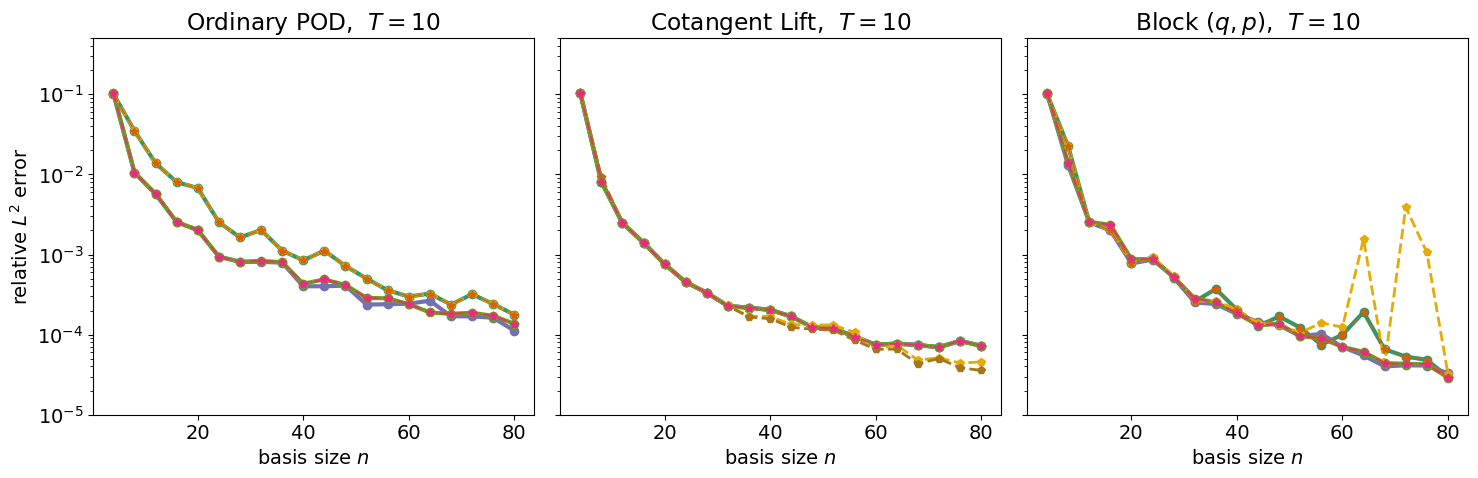

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
ax[0].set_ylabel('relative $L^2$ error')

titleList = [f'Ordinary POD,  $T={Ttest}$', 
                f'Cotangent Lift,  $T={Ttest}$',
                f'Block $(q,p)$,  $T={Ttest}$']
alpha=1

for i in range(len(rom_list)):

    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for OpInf GROM (original) are {eOpGno[i]}')
    print(f'{i} the relative L2 errors for OpInf GROM (reprojected) are {eOpGre[i]}')    
    print(f'{i} the relative L2 errors for intrusive HROM (inconsistent) are {eIntHinc[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM (consistent) are {eIntHcon[i]}')
    print(f'{i} the relative L2 errors for OpInf HROM (original) are {eOpHno[i]}')
    print(f'{i} the relative L2 errors for OpInf HROM (reprojected) are {eOpHre[i]}' + '\n')
    
    ax.flatten()[i].semilogy(nList, eIntG[i], 
                                label='Intrusive G-ROM (MC)',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color = cmap.colors[0])
    ax.flatten()[i].semilogy(nList, eIntHinc[i],
                                label='Intrusive H-ROM (MC, inconsistent)',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color=cmap.colors[2])
    ax.flatten()[i].semilogy(nList, eIntHcon[i],
                                label='Intrusive H-ROM (MC, consistent)',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color=cmap.colors[4])
    ax.flatten()[i].semilogy(nList, eOpGno[i], 
                                label='OpInf G-ROM (MC, original)',
                                marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
                                color=cmap.colors[5])
    ax.flatten()[i].semilogy(nList, eOpHno[i], 
                                label='OpInf H-ROM (MC, original)',
                                marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
                                color=cmap.colors[6])
    ax.flatten()[i].semilogy(nList, eOpGre[i], 
                                label='OpInf G-ROM (MC, reprojected)',
                                marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
                                color=cmap.colors[1])
    ax.flatten()[i].semilogy(nList, eOpHre[i], 
                                label='OpInf H-ROM (MC, reprojected)',
                                marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
                                color=cmap.colors[3])

    ax.flatten()[i].set_ylim([10**-5, 5*10**-1])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    # ax.flatten()[i].legend(prop={'size':8}, loc=3)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
plt.savefig(f'WavePlotT{Ttest}.pdf', transparent=True)
plt.show()

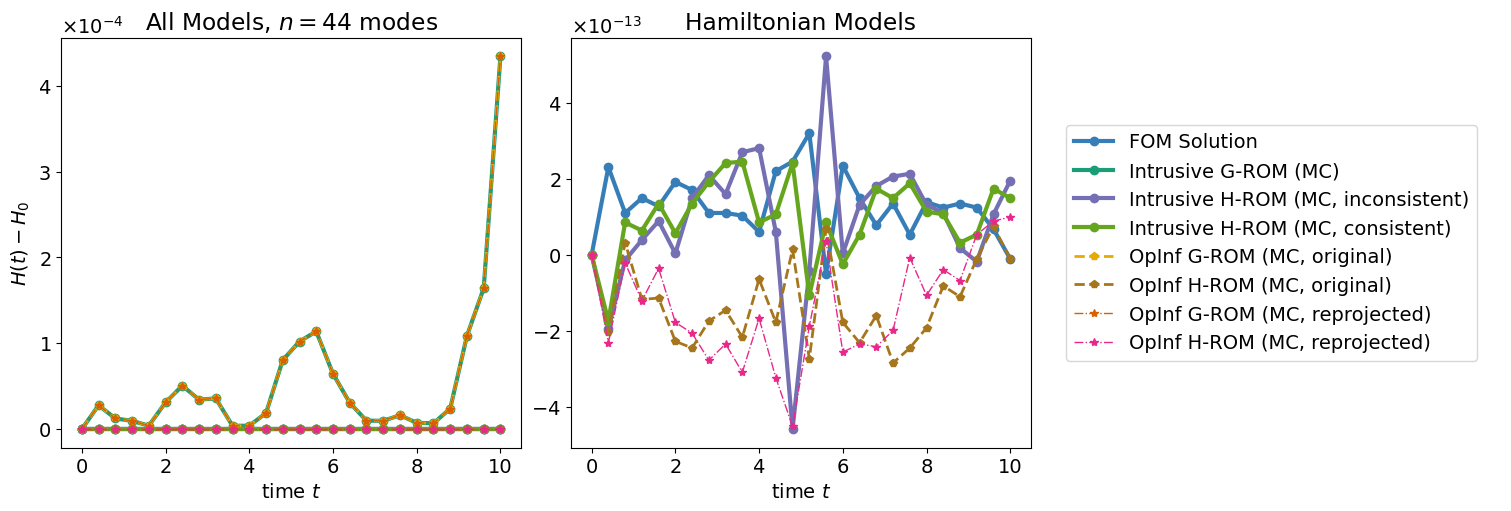

In [24]:
name = "Dark2"
cmap = plt.get_cmap(name)
name = "Set1"
dmap = plt.get_cmap(name)


plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True)

skip=20

i,j = 0,10

titleList   = [f'All Models, $n={4*(j+1)}$ modes', 'Hamiltonian Models']


ax.flatten()[0].plot(tTest[::skip], exactE[::skip]-exactE[0], 
                                label='FOM Solution',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color = dmap.colors[1])
ax.flatten()[0].plot(tTest[::skip], HamIntG[i,j][::skip], 
                                label='Intrusive G-ROM (MC)',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color = cmap.colors[0])
ax.flatten()[0].plot(tTest[::skip], HamIntHinc[i,j][::skip],
                            label='Intrusive H-ROM (MC, inconsistent)',
                            marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                            color=cmap.colors[2])
ax.flatten()[0].plot(tTest[::skip], HamIntHcon[i,j][::skip],
                            label='Intrusive H-ROM (MC, consistent)',
                            marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                            color=cmap.colors[4])
ax.flatten()[0].plot(tTest[::skip], HamOpGno[i,j][::skip], 
                            label='OpInf G-ROM (MC, original)',
                            marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
                            color=cmap.colors[5])
ax.flatten()[0].plot(tTest[::skip], HamOpHno[i,j][::skip], 
                            label='OpInf H-ROM (MC, original)',
                            marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
                            color=cmap.colors[6])
ax.flatten()[0].plot(tTest[::skip], HamOpGre[i,j][::skip], 
                            label='OpInf G-ROM (MC, reprojected)',
                            marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
                            color=cmap.colors[1])
ax.flatten()[0].plot(tTest[::skip], HamOpHre[i,j][::skip], 
                            label='OpInf H-ROM (MC, reprojected)',
                            marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
                            color=cmap.colors[3])


ax.flatten()[1].plot(tTest[::skip], exactE[::skip]-exactE[0], 
                                label='FOM Solution',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color = dmap.colors[1])
# ax.flatten()[1].plot(tTest[::skip], HamIntG[i,j][::skip], 
#                                 label='Intrusive G-ROM (MC)',
#                                 marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
#                                 color = cmap.colors[0])
ax.flatten()[1].plot(tTest[::skip], HamIntHinc[i,j][::skip],
                            label='Intrusive H-ROM (MC, inconsistent)',
                            marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                            color=cmap.colors[2])
ax.flatten()[1].plot(tTest[::skip], HamIntHcon[i,j][::skip],
                            label='Intrusive H-ROM (MC, consistent)',
                            marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                            color=cmap.colors[4])
# ax.flatten()[1].plot(tTest[::skip], HamOpGno[i,j][::skip], 
#                             label='OpInf G-ROM (MC, original)',
#                             marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
#                             color=cmap.colors[5])
ax.flatten()[1].plot(tTest[::skip], HamOpHno[i,j][::skip], 
                            label='OpInf H-ROM (MC, original)',
                            marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
                            color=cmap.colors[6])
# ax.flatten()[1].plot(tTest[::skip], HamOpGre[i,j][::skip], 
#                             label='OpInf G-ROM (MC, reprojected)',
#                             marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
#                             color=cmap.colors[1])
ax.flatten()[1].plot(tTest[::skip], HamOpHre[i,j][::skip], 
                            label='OpInf H-ROM (MC, reprojected)',
                            marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
                            color=cmap.colors[3])

lines, labels = ax[0].get_legend_handles_labels()

ax[2].axis('off')
ax[2].legend(lines, labels, loc='center', ncol=1)

ax[0].set_ylabel(r'$H(t) - H_0$')
for i in range(2):
    ax[i].set_xlabel('time $t$')
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax[i].set_title(titleList[i])
# ax.flatten()[0].legend(prop={'size':8})
# plt.suptitle(f'Hamiltonian Error, $n={4*(j+1)}$ modes')

# plt.tight_layout()
plt.savefig(f'WaveEnergyT{Ttest}.pdf', transparent=True)
plt.show()


### Testing the nonparametric version (T=100)

With and without mean centering, symplectic lift, and one shot OpInf.


In [25]:
# Asp = csc_matrix(A)

# A = csc_matrix(A)
# J = csc_matrix(J)

### Exact solution
Ttest     = 100
NtTest    = 501
tTest     = np.linspace(0, Ttest, NtTest)
ic  = ICgrid[0]
Xac = ru.integrate_Linear_HFOM(tTest, ic, J, A)[0]
dx  = xTrain[1]-xTrain[0]
exactE = ru.compute_Hamiltonian(Xac, A)

### Parameters
rom_list = [PODmc, SVDmc, QPmc]
nList    = [4*(i+1) for i in range(20)]
N        = 2*Nover2
xData    = X1 
xDotData = Xt1

# fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
# ax[0].set_ylabel('relative $L^2$ error')

titleList = ['Ordinary POD', 
                'Cotangent Lift',
                'Block $(q,p)$']
alpha=1

XrecIntG    = np.zeros((3, len(nList), N, NtTest))
XrecOpGno   = np.zeros((3, len(nList), N, NtTest))
XrecOpGre   = np.zeros((3, len(nList), N, NtTest))
XrecIntHinc = np.zeros((3, len(nList), N, NtTest))
XrecIntHcon = np.zeros((3, len(nList), N, NtTest))
XrecOpHno   = np.zeros((3, len(nList), N, NtTest))
XrecOpHre   = np.zeros((3, len(nList), N, NtTest))

for i in range(len(rom_list)):

    rom = rom_list[i]
    print(f'solutions {titleList[i]}')

    # This is a hack.  Should fix eventually....
    rom.A = A
    rom.J = J

    for j,n in enumerate(nList):
        print(f'n = {n}')

        rom.assemble_naive_ROM(n, J, A)
        # try:
        rom.integrate_naive_ROM(tTest) 
        XrecIntG[i,j] = rom.decode(rom.x_hat)
        # except: pass

        rom.infer_generic(n, xData, xDotData, eps=0.0e-5,
                            reproject=False)
        try: 
            rom.integrate_naive_ROM(tTest)
            XrecOpGno[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_generic(n, xData, xDotData, eps=0.0e-5, 
                            reproject=True)
        try: 
            rom.integrate_naive_ROM(tTest)
            XrecOpGre[i,j] = rom.decode(rom.x_hat)
        except: pass

        rom.assemble_Hamiltonian_ROM(n, J, A)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, 
                                        inconsistent=True) 
            XrecIntHinc[i,j] = rom.decode(rom.x_hat)
        except: pass
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, 
                                        inconsistent=False) 
            XrecIntHcon[i,j] = rom.decode(rom.x_hat)
        except: pass

        rom.infer_canonical_Hamiltonian(n, xData, xDotData, J, eps=0.0e-5, 
                                        old=False, reproject=False)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9,
                                        inconsistent=False)
            XrecOpHno[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_canonical_Hamiltonian(n, xData, xDotData, J, eps=0.0e-5, 
                                        old=False, reproject=True)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9,
                                        inconsistent=False)
            XrecOpHre[i,j] = rom.decode(rom.x_hat)
        except: pass

eIntG    = np.zeros((3, len(nList)))
eOpGno   = np.zeros((3, len(nList)))
eOpGre   = np.zeros((3, len(nList)))
eIntHinc = np.zeros((3, len(nList)))
eIntHcon = np.zeros((3, len(nList)))
eOpHno   = np.zeros((3, len(nList)))
eOpHre   = np.zeros((3, len(nList)))

HamIntG    = np.zeros((3, len(nList), NtTest))
HamOpGno   = np.zeros((3, len(nList), NtTest))
HamOpGre   = np.zeros((3, len(nList), NtTest))
HamIntHinc = np.zeros((3, len(nList), NtTest))
HamIntHcon = np.zeros((3, len(nList), NtTest))
HamOpHno   = np.zeros((3, len(nList), NtTest))
HamOpHre   = np.zeros((3, len(nList), NtTest))

for i in range(len(rom_list)):
    print(f'errors {titleList[i]}')

    for j,n in enumerate(nList):
        print(f'n = {n}')

        eIntG[i,j]    = ru.relError(Xac, XrecIntG[i,j])
        eOpGno[i,j]   = ru.relError(Xac, XrecOpGno[i,j])
        eOpGre[i,j]   = ru.relError(Xac, XrecOpGre[i,j])
        eIntHinc[i,j] = ru.relError(Xac, XrecIntHinc[i,j])
        eIntHcon[i,j] = ru.relError(Xac, XrecIntHcon[i,j])
        eOpHno[i,j]   = ru.relError(Xac, XrecOpHno[i,j])
        eOpHre[i,j]   = ru.relError(Xac, XrecOpHre[i,j])

        HamIntG[i,j]    = ru.compute_Hamiltonian(XrecIntG[i,j], A) - exactE
        HamOpGno[i,j]   = ru.compute_Hamiltonian(XrecOpGno[i,j], A) - exactE
        HamOpGre[i,j]   = ru.compute_Hamiltonian(XrecOpGre[i,j], A) - exactE
        HamIntHinc[i,j] = ru.compute_Hamiltonian(XrecIntHinc[i,j], A) - exactE
        HamIntHcon[i,j] = ru.compute_Hamiltonian(XrecIntHcon[i,j], A) - exactE
        HamOpHno[i,j]   = ru.compute_Hamiltonian(XrecOpHno[i,j], A) - exactE
        HamOpHre[i,j]   = ru.compute_Hamiltonian(XrecOpHre[i,j], A) - exactE


solutions Ordinary POD
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
solutions Cotangent Lift
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
solutions Block $(q,p)$
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
errors Ordinary POD
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
errors Cotangent Lift
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
errors Block $(q,p)$
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80


0 the relative L2 errors for intrusive GROM are [0.13359471 0.3684577  0.13943368 0.07673634 0.04142575 0.01190188
 0.00978206 0.06846857 0.00735084 0.00532753 0.01216122 0.00316498
 0.00282108 0.00263306 0.00908987 0.00145539 0.00083806 0.00159905
 0.01741003 0.00049935]
0 the relative L2 errors for OpInf GROM (original) are [0.13359471 0.3684577  0.13943368 0.07673634 0.04142575 0.01190188
 0.00978206 0.06846857 0.00735084 0.00532753 0.01216122 0.00316498
 0.00282108 0.00263306 0.00908987 0.00145539 0.00083806 0.00159905
 0.01741003 0.00049935]
0 the relative L2 errors for OpInf GROM (reprojected) are [0.13359471 0.3684577  0.13943368 0.07673634 0.04142575 0.01190188
 0.00978206 0.06846857 0.00735084 0.00532753 0.01216122 0.00316498
 0.00282108 0.00263306 0.00908987 0.00145539 0.00083806 0.00159905
 0.01741003 0.00049935]
0 the relative L2 errors for intrusive HROM (inconsistent) are [0.1367008  0.01127019 0.01135253 0.00296512 0.00345326 0.00126531
 0.00126729 0.00127331 0.00105796 

/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_29438/1252100496.py:54: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


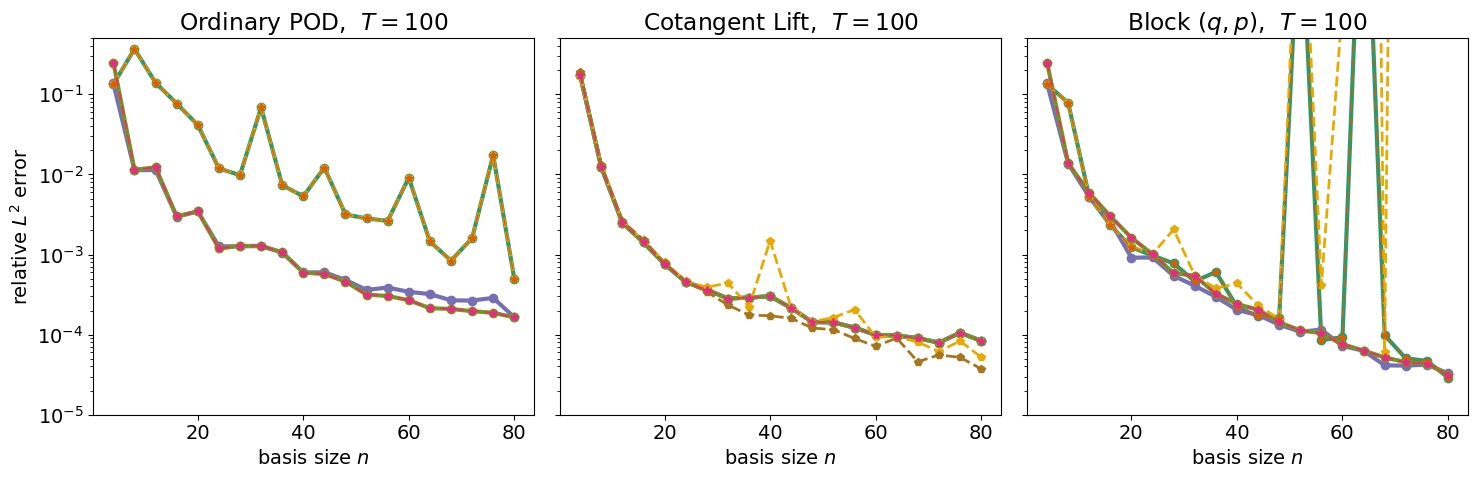

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
ax[0].set_ylabel('relative $L^2$ error')

titleList = [f'Ordinary POD,  $T={Ttest}$', 
                f'Cotangent Lift,  $T={Ttest}$',
                f'Block $(q,p)$,  $T={Ttest}$']
alpha=1

for i in range(len(rom_list)):

    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for OpInf GROM (original) are {eOpGno[i]}')
    print(f'{i} the relative L2 errors for OpInf GROM (reprojected) are {eOpGre[i]}')    
    print(f'{i} the relative L2 errors for intrusive HROM (inconsistent) are {eIntHinc[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM (consistent) are {eIntHcon[i]}')
    print(f'{i} the relative L2 errors for OpInf HROM (original) are {eOpHno[i]}')
    print(f'{i} the relative L2 errors for OpInf HROM (reprojected) are {eOpHre[i]}' + '\n')
    
    ax.flatten()[i].semilogy(nList, eIntG[i], 
                                label='Intrusive G-ROM (MC)',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color = cmap.colors[0])
    ax.flatten()[i].semilogy(nList, eIntHinc[i],
                                label='Intrusive H-ROM (MC, inconsistent)',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color=cmap.colors[2])
    ax.flatten()[i].semilogy(nList, eIntHcon[i],
                                label='Intrusive H-ROM (MC, consistent)',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color=cmap.colors[4])
    ax.flatten()[i].semilogy(nList, eOpGno[i], 
                                label='OpInf G-ROM (MC, original)',
                                marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
                                color=cmap.colors[5])
    ax.flatten()[i].semilogy(nList, eOpHno[i], 
                                label='OpInf H-ROM (MC, original)',
                                marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
                                color=cmap.colors[6])
    ax.flatten()[i].semilogy(nList, eOpGre[i], 
                                label='OpInf G-ROM (MC, reprojected)',
                                marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
                                color=cmap.colors[1])
    ax.flatten()[i].semilogy(nList, eOpHre[i], 
                                label='OpInf H-ROM (MC, reprojected)',
                                marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
                                color=cmap.colors[3])

    ax.flatten()[i].set_ylim([10**-5, 5*10**-1])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    # ax.flatten()[i].legend(prop={'size':8}, loc=3)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
plt.savefig(f'WavePlotT{Ttest}.pdf', transparent=True)
plt.show()

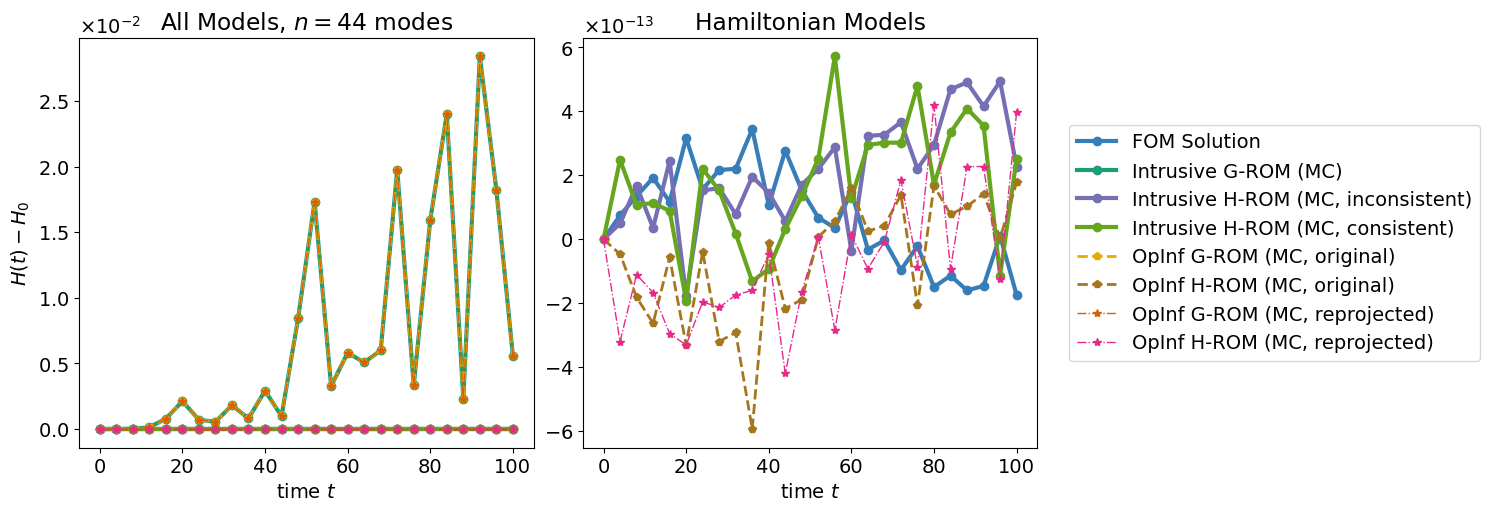

In [27]:
name = "Dark2"
cmap = plt.get_cmap(name)
name = "Set1"
dmap = plt.get_cmap(name)


plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True)

skip=20

i,j = 0,10

titleList   = [f'All Models, $n={4*(j+1)}$ modes', 'Hamiltonian Models']


ax.flatten()[0].plot(tTest[::skip], exactE[::skip]-exactE[0], 
                                label='FOM Solution',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color = dmap.colors[1])
ax.flatten()[0].plot(tTest[::skip], HamIntG[i,j][::skip], 
                                label='Intrusive G-ROM (MC)',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color = cmap.colors[0])
ax.flatten()[0].plot(tTest[::skip], HamIntHinc[i,j][::skip],
                            label='Intrusive H-ROM (MC, inconsistent)',
                            marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                            color=cmap.colors[2])
ax.flatten()[0].plot(tTest[::skip], HamIntHcon[i,j][::skip],
                            label='Intrusive H-ROM (MC, consistent)',
                            marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                            color=cmap.colors[4])
ax.flatten()[0].plot(tTest[::skip], HamOpGno[i,j][::skip], 
                            label='OpInf G-ROM (MC, original)',
                            marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
                            color=cmap.colors[5])
ax.flatten()[0].plot(tTest[::skip], HamOpHno[i,j][::skip], 
                            label='OpInf H-ROM (MC, original)',
                            marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
                            color=cmap.colors[6])
ax.flatten()[0].plot(tTest[::skip], HamOpGre[i,j][::skip], 
                            label='OpInf G-ROM (MC, reprojected)',
                            marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
                            color=cmap.colors[1])
ax.flatten()[0].plot(tTest[::skip], HamOpHre[i,j][::skip], 
                            label='OpInf H-ROM (MC, reprojected)',
                            marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
                            color=cmap.colors[3])


ax.flatten()[1].plot(tTest[::skip], exactE[::skip]-exactE[0], 
                                label='FOM Solution',
                                marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                                color = dmap.colors[1])
# ax.flatten()[1].plot(tTest[::skip], HamIntG[i,j][::skip], 
#                                 label='Intrusive G-ROM (MC)',
#                                 marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
#                                 color = cmap.colors[0])
ax.flatten()[1].plot(tTest[::skip], HamIntHinc[i,j][::skip],
                            label='Intrusive H-ROM (MC, inconsistent)',
                            marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                            color=cmap.colors[2])
ax.flatten()[1].plot(tTest[::skip], HamIntHcon[i,j][::skip],
                            label='Intrusive H-ROM (MC, consistent)',
                            marker='o', linestyle='-', linewidth=3.0, markersize=6, alpha=alpha,
                            color=cmap.colors[4])
# ax.flatten()[1].plot(tTest[::skip], HamOpGno[i,j][::skip], 
#                             label='OpInf G-ROM (MC, original)',
#                             marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
#                             color=cmap.colors[5])
ax.flatten()[1].plot(tTest[::skip], HamOpHno[i,j][::skip], 
                            label='OpInf H-ROM (MC, original)',
                            marker='p', linestyle='--', linewidth=2.0, markersize=6, alpha=alpha,
                            color=cmap.colors[6])
# ax.flatten()[1].plot(tTest[::skip], HamOpGre[i,j][::skip], 
#                             label='OpInf G-ROM (MC, reprojected)',
#                             marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
#                             color=cmap.colors[1])
ax.flatten()[1].plot(tTest[::skip], HamOpHre[i,j][::skip], 
                            label='OpInf H-ROM (MC, reprojected)',
                            marker='*', linestyle='-.', linewidth=1.0, markersize=6, alpha=alpha,
                            color=cmap.colors[3])

lines, labels = ax[0].get_legend_handles_labels()

ax[2].axis('off')
ax[2].legend(lines, labels, loc='center', ncol=1)

ax[0].set_ylabel(r'$H(t) - H_0$')
for i in range(2):
    ax[i].set_xlabel('time $t$')
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax[i].set_title(titleList[i])
# ax.flatten()[0].legend(prop={'size':8})
# plt.suptitle(f'Hamiltonian Error, $n={4*(j+1)}$ modes')

# plt.tight_layout()
plt.savefig(f'WaveEnergyT{Ttest}.pdf', transparent=True)
plt.show()


## Make movie of solutions

In [11]:
# Asp = csc_matrix(A)

# A = csc_matrix(A)
# J = csc_matrix(J)

### Exact solution
Ttest     = 100
NtTest    = 1501
tTest     = np.linspace(0, Ttest, NtTest)
ic  = ICgrid[0]
Xac = ru.integrate_Linear_HFOM(tTest, ic, J, A)[0]
dx  = xTrain[1]-xTrain[0]
exactE = ru.compute_Hamiltonian(Xac, A)

### Parameters
rom_list = [POD, SVD, QP]
nList    = [4*(i+1) for i in range(20)]
N        = 2*Nover2
xData    = X1 
xDotData = Xt1

# fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
# ax[0].set_ylabel('relative $L^2$ error')

titleList = ['Ordinary POD', 
                'Cotangent Lift',
                'Block $(q,p)$']
alpha=1

XrecIntG    = np.zeros((3, len(nList), N, NtTest))
XrecOpGno   = np.zeros((3, len(nList), N, NtTest))
XrecOpGre   = np.zeros((3, len(nList), N, NtTest))
XrecIntHinc = np.zeros((3, len(nList), N, NtTest))
XrecIntHcon = np.zeros((3, len(nList), N, NtTest))
XrecOpHno   = np.zeros((3, len(nList), N, NtTest))
XrecOpHre   = np.zeros((3, len(nList), N, NtTest))

for i in range(len(rom_list)):

    rom = rom_list[i]
    print(f'solutions {titleList[i]}')

    # This is a hack.  Should fix eventually....
    rom.A = A
    rom.J = J

    for j,n in enumerate(nList):
        print(f'n = {n}')

        rom.assemble_naive_ROM(n, J, A)
        # try:
        rom.integrate_naive_ROM(tTest) 
        XrecIntG[i,j] = rom.decode(rom.x_hat)
        # except: pass

        rom.infer_generic(n, xData, xDotData, eps=0.0e-5,
                            reproject=False)
        try: 
            rom.integrate_naive_ROM(tTest)
            XrecOpGno[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_generic(n, xData, xDotData, eps=0.0e-5, 
                            reproject=True)
        try: 
            rom.integrate_naive_ROM(tTest)
            XrecOpGre[i,j] = rom.decode(rom.x_hat)
        except: pass

        rom.assemble_Hamiltonian_ROM(n, J, A)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, 
                                        inconsistent=True) 
            XrecIntHinc[i,j] = rom.decode(rom.x_hat)
        except: pass
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, 
                                        inconsistent=False) 
            XrecIntHcon[i,j] = rom.decode(rom.x_hat)
        except: pass

        rom.infer_canonical_Hamiltonian(n, xData, xDotData, J, eps=0.0e-5, 
                                        old=False, reproject=False)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9,
                                        inconsistent=False)
            XrecOpHno[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_canonical_Hamiltonian(n, xData, xDotData, J, eps=0.0e-5, 
                                        old=False, reproject=True)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9,
                                        inconsistent=False)
            XrecOpHre[i,j] = rom.decode(rom.x_hat)
        except: pass

eIntG    = np.zeros((3, len(nList)))
eOpGno   = np.zeros((3, len(nList)))
eOpGre   = np.zeros((3, len(nList)))
eIntHinc = np.zeros((3, len(nList)))
eIntHcon = np.zeros((3, len(nList)))
eOpHno   = np.zeros((3, len(nList)))
eOpHre   = np.zeros((3, len(nList)))

HamIntG    = np.zeros((3, len(nList), NtTest))
HamOpGno   = np.zeros((3, len(nList), NtTest))
HamOpGre   = np.zeros((3, len(nList), NtTest))
HamIntHinc = np.zeros((3, len(nList), NtTest))
HamIntHcon = np.zeros((3, len(nList), NtTest))
HamOpHno   = np.zeros((3, len(nList), NtTest))
HamOpHre   = np.zeros((3, len(nList), NtTest))

for i in range(len(rom_list)):
    print(f'errors {titleList[i]}')

    for j,n in enumerate(nList):
        print(f'n = {n}')

        eIntG[i,j]    = ru.relError(Xac, XrecIntG[i,j])
        eOpGno[i,j]   = ru.relError(Xac, XrecOpGno[i,j])
        eOpGre[i,j]   = ru.relError(Xac, XrecOpGre[i,j])
        eIntHinc[i,j] = ru.relError(Xac, XrecIntHinc[i,j])
        eIntHcon[i,j] = ru.relError(Xac, XrecIntHcon[i,j])
        eOpHno[i,j]   = ru.relError(Xac, XrecOpHno[i,j])
        eOpHre[i,j]   = ru.relError(Xac, XrecOpHre[i,j])

        HamIntG[i,j]    = ru.compute_Hamiltonian(XrecIntG[i,j], A) - exactE
        HamOpGno[i,j]   = ru.compute_Hamiltonian(XrecOpGno[i,j], A) - exactE
        HamOpGre[i,j]   = ru.compute_Hamiltonian(XrecOpGre[i,j], A) - exactE
        HamIntHinc[i,j] = ru.compute_Hamiltonian(XrecIntHinc[i,j], A) - exactE
        HamIntHcon[i,j] = ru.compute_Hamiltonian(XrecIntHcon[i,j], A) - exactE
        HamOpHno[i,j]   = ru.compute_Hamiltonian(XrecOpHno[i,j], A) - exactE
        HamOpHre[i,j]   = ru.compute_Hamiltonian(XrecOpHre[i,j], A) - exactE


solutions Ordinary POD
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
solutions Cotangent Lift
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
solutions Block $(q,p)$
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
errors Ordinary POD
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
errors Cotangent Lift
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80
errors Block $(q,p)$
n = 4
n = 8
n = 12
n = 16
n = 20
n = 24
n = 28
n = 32
n = 36
n = 40
n = 44
n = 48
n = 52
n = 56
n = 60
n = 64
n = 68
n = 72
n = 76
n = 80


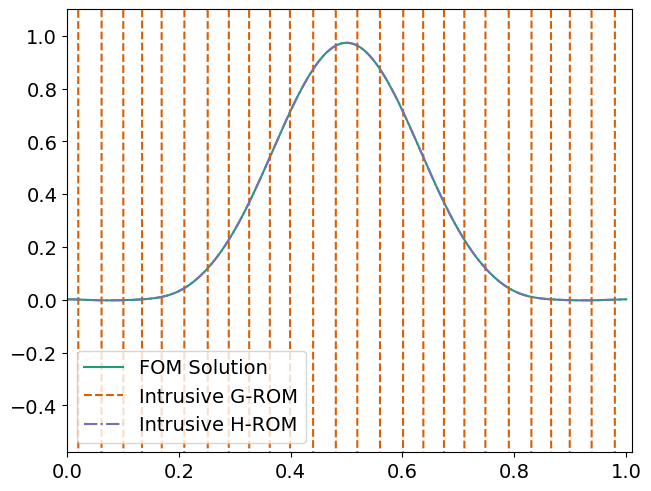

In [17]:
### Make movie of solutions
i,j=0,5

ymin = (XrecIntHinc.min()*(1-0.1) if XrecIntHinc.min() > 0 else XrecIntHinc.min()*(1+0.1))
ymax = (XrecIntHinc.max()*(1+0.1) if XrecIntHinc.max() > 0 else XrecIntHinc.max()*(1-0.1))

arrs = np.array([Xac[:Nover2], XrecIntG[i,j][:Nover2], XrecIntHinc[i,j][:Nover2]])
styles = ['-', '--', '-.']
labels = ['FOM Solution', 'Intrusive G-ROM', 'Intrusive H-ROM']

ru.animate_array(arrs, styles, labels, np.array(xTrain), 
              yLims=[ymin, ymax], legend_loc=3, colorIdx=[0,1,2])

# ### Make movie of solutions
# i,j=0,5

# ymin = (XrecIntHinc.min()*(1-0.1) if XrecIntHinc.min() > 0 else XrecIntHinc.min()*(1+0.1))
# ymax = (XrecIntHinc.max()*(1+0.1) if XrecIntHinc.max() > 0 else XrecIntHinc.max()*(1-0.1))

# arrs = np.array([Xac[:Nover2], XrecIntG[i,j][:Nover2]])
# styles = ['-', '--']
# labels = ['FOM Solution', 'Intrusive G-ROM']

# ru.animate_array(arrs, styles, labels, np.array(xTrain), 
#               yLims=[ymin, ymax], legend_loc=3, colorIdx=[0,1])

# ### Make movie of solutions
# i,j=0,5

# ymin = (XrecIntHinc.min()*(1-0.1) if XrecIntHinc.min() > 0 else XrecIntHinc.min()*(1+0.1))
# ymax = (XrecIntHinc.max()*(1+0.1) if XrecIntHinc.max() > 0 else XrecIntHinc.max()*(1-0.1))

# arrs = np.array([Xac[:Nover2], XrecIntHinc[i,j][:Nover2]])
# styles = ['-', '--']
# labels = ['FOM Solution', 'Intrusive H-ROM']

# ru.animate_array(arrs, styles, labels, np.array(xTrain),
#                  yLims=[ymin, ymax], legend_loc=3, colorIdx=[0,2])